In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import json
from tqdm import tqdm,tqdm_notebook
import os
print(os.listdir("../input"))

['sample_submission.csv', 'train', 'test', 'train.csv']


(17500, 2)
(32, 32, 3)


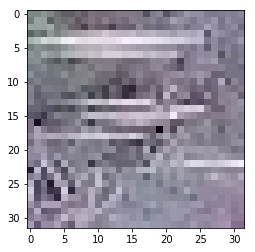

In [3]:
train_df=pd.read_csv("../input/train.csv")
train_df["has_cactus"]=train_df["has_cactus"].map(lambda x:str(x))
print(train_df.shape)

import cv2
image=cv2.imread("../input/train/train/0004be2cfeaba1c0361d39e2b000257b.jpg"
                )
plt.imshow(image)
print(image.shape)

In [4]:
from keras.models import Sequential
from keras.layers import Activation,Dropout,Flatten,Dense,MaxPooling2D
from keras.applications import ResNet50
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers

Using TensorFlow backend.


In [5]:
base_model=ResNet50(weights="imagenet",include_top=False,input_shape=(32,32,3))

Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 7s 0us/step


In [6]:
def add_new_layer(base_model):
    x=base_model.output
    x=Flatten()(x)
    x=Dense(1024,activation="relu")(x)
    predictions = Dense(1, activation='sigmoid',activity_regularizer=regularizers.l1(0.05))(x)
    model = Model(input=base_model.input, output=predictions)
    return model
def transfer_learn(model, base_model):
    for layer in base_model.layers:
        layer.trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy',
                  metrics=['accuracy'])

In [7]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255,
                                 validation_split=0.1,
                                 rotation_range=30,
                                 shear_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 zoom_range=0.2)
train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/train/train",
    x_col="id",
    y_col="has_cactus",
    batch_size=32,
    shuffle=True,
    class_mode="binary",
    target_size=(32,32),
    subset='training')
validation_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/train/train",
    x_col="id",
    y_col="has_cactus",
    batch_size=32,
    shuffle=True,
    class_mode="binary",
    target_size=(32,32),
    subset='validation')

Found 15750 images belonging to 2 classes.
Found 1750 images belonging to 2 classes.


In [8]:
model=add_new_layer(base_model)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [9]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [10]:
transfer_learn(model, base_model)

In [11]:
history=model.fit_generator(generator=train_generator,
                            validation_data=validation_generator,
                            validation_steps=int(train_df.shape[0]/32),
                            steps_per_epoch=int(train_df.shape[0]/32),
                            epochs=10,
                            verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
546/546 [==============================] - 107s 195ms/step - loss: 1.1921 - acc: 0.8891 - val_loss: 1.1514 - val_acc: 0.9686
Epoch 2/10
546/546 [==============================] - 73s 133ms/step - loss: 1.1588 - acc: 0.9459 - val_loss: 1.1142 - val_acc: 0.9731
Epoch 3/10
546/546 [==============================] - 72s 132ms/step - loss: 1.1454 - acc: 0.9654 - val_loss: 1.1005 - val_acc: 0.9846
Epoch 4/10
546/546 [==============================] - 73s 133ms/step - loss: 1.1251 - acc: 0.9768 - val_loss: 1.0947 - val_acc: 0.9896
Epoch 5/10
546/546 [==============================] - 72s 132ms/step - loss: 1.1250 - acc: 0.9796 - val_loss: 1.1056 - val_acc: 0.9941
Epoch 6/10
546/546 [==============================] - 72s 132ms/step - loss: 1.1199 - acc: 0.9838 - val_loss: 1.0966 - val_acc: 0.9837
Epoch 7/10
546/546 [==============================] - 71s 130ms/step - loss: 1.1369 - acc: 0.9788 - val_loss: 1.1027 - val_acc: 0.9815
Epoch 

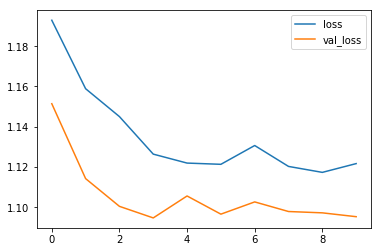

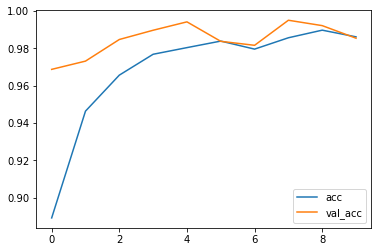

In [12]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [13]:
train_dir=r"../input/train/train/"
test_dir=r"../input/test/test/"
X_test=[]
X_image=[]
for image in tqdm_notebook(os.listdir(test_dir)):
    im=cv2.imread(test_dir+image)
    X_test.append(im)
    X_image.append(image)
X_test=np.array(X_test)
X_test=X_test/255.0


In [14]:
print(X_test.shape)

(4000, 32, 32, 3)


In [15]:
test_predictions=model.predict(X_test)

In [16]:
submission=pd.DataFrame(test_predictions,columns=['has_cactus'])

In [17]:
submission['id'] = ''
cols=list(submission.columns)
cols = cols[-1:] + cols[:-1]
submission=submission[cols]
for i, img in enumerate(X_image):
    submission.set_value(i,'id',img)
print(submission)

                                        id  has_cactus
0     dadfb5ca7c1ded00aac585bdbea2c66c.jpg    0.632025
1     7f8ee9354b1a12c01832ee4115d703e8.jpg    0.513841
2     546cb4e0e46927319d60c5b6d64521a2.jpg    0.006490
3     ad7540778cc3cfdcc1ee326ae4659af8.jpg    0.483983
4     fd4f6c93466b6c3438e1d7b616328b00.jpg    0.624338
5     03854bb8a431afcc9995d639d7761055.jpg    0.674605
6     ab4b86f50eb4d2b936719b5f31fd1ed4.jpg    0.540616
7     3d497d059c2c5a5680c7aab6dbe9d8c8.jpg    0.622941
8     119f2dd44df56fa4d8032199f4231353.jpg    0.105931
9     588be7b33f883603211bdb77f394c4ed.jpg    0.633033
10    3d6482ba8f1c1271292cc6120c81fadf.jpg    0.663275
11    b4dfabc9c484997596390adfb4a2575e.jpg    0.626583
12    8bcfbe6e26f94812e976df1b0cc9a961.jpg    0.632412
13    210a05c45336a587bc7a626e98703ad8.jpg    0.521391
14    afb478de3752ac34f53b577945a98f78.jpg    0.625519
15    b0e00121e43ba5e9f975887e34a4c639.jpg    0.403565
16    b9a5255ca6581ccde7d8606963c0295b.jpg    0.068034
17    668c

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [18]:
submission.to_csv("submissionn.csv", index=False)